# 5. Training an Anomaly Detection Model for Covid Anomaly Detection

In this tutorial, we will train an anomaly detection model using a simple [LSTM-AutoEncoder model](https://www.medrxiv.org/content/10.1101/2021.01.08.21249474v1).
Data can be obtained from [this link](https://iscteiul365-my.sharepoint.com/:u:/g/personal/oonia_iscte-iul_pt/ERZLm1ruUNpMqkSwjpqhE9wB_7loVWAC4yZWuIH2RKGOlQ?e=kD4HlI). This is a processed version of data from original Stanford dataset-Phase 2. The overall pre-processing pipeline used is illustrated in Figure below.

![preprocessing](stanford_data_processing.png)

Data was aquired from diferent sources (Germin, FitBit, Apple Watch) and pre-processed to have a common format. In this form, data has two columns: heart rate and number of user steps in last minute. 
Then the processing pipeline was applied to the data. The pipeline is composed of the following steps:
1. Once data was standardized, the resting heart rate was extracted (``Resting Heart Rate Extractor``, in Figure). This process takes as input `min_minutes_rest` that is the number of minutes that the user has to be at rest to consider the heart rate as resting. This variable looks at user steps and, when user steps is 0 for `min_minutes_rest` minutes, the heart rate is considered as resting. At the end of this process, we will have a new dataframe with: the date and the resting heart rate of the last minute.
2. The second step is adding labels.

In [1]:
import pandas as pd
from ssl_tools.data.data_modules.covid_anomaly import CovidUserAnomalyDataModule
from ssl_tools.utils.data import get_full_data_split
from ssl_tools.models.nets.lstm_ae import LSTMAutoencoder
import lightning as L
import torch
import numpy as np
from torchmetrics import MeanSquaredError

In [2]:
# Read CSV data
data_path = "/workspaces/hiaac-m4/data/Stanford-COVID/processed/windowed_16_overlap_8_df_scaled.csv"
df = pd.read_csv(data_path)
df

datetime     RHR-0     RHR-1     RHR-2     RHR-3     RHR-4  \
0      2027-01-14 21:00:00  1.170175  0.653752 -0.392374 -1.431553 -2.129013   
1      2027-01-15 05:00:00 -5.668570 -6.373289 -6.937363 -7.102118 -6.975790   
2      2027-01-15 13:00:00 -4.415848 -3.467073 -2.656756 -1.305630 -0.072756   
3      2027-01-15 21:00:00  1.223064  0.472444 -0.424000 -1.145581 -1.355121   
4      2027-01-16 05:00:00 -4.802627 -5.831013 -6.067744 -5.460156 -4.671143   
...                    ...       ...       ...       ...       ...       ...   
31732  2024-12-13 00:00:00 -0.180702 -0.499793 -0.749829 -0.868485 -0.966754   
31733  2024-12-13 08:00:00 -0.467943 -0.162740  0.092000  0.347840  0.636395   
31734  2024-12-13 16:00:00  1.477526  1.657321  1.660344  1.656600  1.685652   
31735  2024-12-14 00:00:00  1.728615  1.616265  1.509833  1.380749  1.263744   
31736  2024-12-14 08:00:00  1.136868  1.380418  1.642153  1.909381  2.114439   

          RHR-5     RHR-6     RHR-7     RHR-8  ...    RHR-10    RHR-11  \
0     -2.755962 -3.681322 -4.674443 -5.668570  ... -6.937363 -7.102118   
1     -6.554774 -6.112156 -5.396099 -4.415848  ... -2.656756 -1.305630   
2      1.046195  1.530467  1.829053  1.223064  ... -0.424000 -1.145581   
3     -2.321206 -3.124961 -3.928738 -4.802627  ... -6.067744 -5.460156   
4     -3.408943 -2.237883 -1.187843 -0.062360  ...  2.266944  3.794465   
...         ...       ...       ...       ...  ...       ...       ...   
31732 -1.004670 -0.888210 -0.580762 -0.467943  ...  0.092000  0.347840   
31733  0.958195  1.170514  1.301841  1.477526  ...  1.660344  1.656600   
31734  1.747252  1.767329  1.793616  1.728615  ...  1.509833  1.380749   
31735  1.139997  1.024205  0.946663  1.136868  ...  1.642153  1.909381   
31736  2.282238  2.453691  2.587843  2.437232  ...  2.359840  2.173400   

         RHR-12    RHR-13    RHR-14    RHR-15  anomaly  baseline      label  \
0     -6.975790 -6.554774 -6.112156 -5.396099    False      True     normal   
1     -0.072756  1.046195  1.530467  1.829053    False     False     normal   
2     -1.355121 -2.321206 -3.124961 -3.928738    False     False     normal   
3     -4.671143 -3.408943 -2.237883 -1.187843    False     False     normal   
4      4.625745  4.827756  4.720000  4.677464    False     False     normal   
...         ...       ...       ...       ...      ...       ...        ...   
31732  0.636395  0.958195  1.170514  1.301841    False     False  recovered   
31733  1.685652  1.747252  1.767329  1.793616    False     False  recovered   
31734  1.263744  1.139997  1.024205  0.946663    False     False  recovered   
31735  2.114439  2.282238  2.453691  2.587843    False     False  recovered   
31736  2.098140  1.967669  1.784512  1.561848    False     False  recovered   

      participant_id  
0            P110465  
1            P110465  
2            P110465  
3            P110465  
4            P110465  
...              ...  
31732        P992022  
31733        P992022  
31734        P992022  
31735        P992022  
31736        P992022  

[31737 rows x 21 columns]

In [3]:
dm = CovidUserAnomalyDataModule(
    data_path,
    participants=["P992022"],
    batch_size=32,
    num_workers=0,
    reshape=(16, 1),
)
dm

CovidUserAnomalyDataModule (Data=/workspaces/hiaac-m4/data/Stanford-COVID/processed/windowed_16_overlap_8_df_scaled.csv, 1 participant selected)

In [4]:
model = LSTMAutoencoder(input_shape=(16, 1))
model

LSTMAutoencoder(
  (backbone): _LSTMAutoEncoder(
    (lstm1): LSTM(1, 128, batch_first=True)
    (lstm2): LSTM(128, 64, batch_first=True)
    (repeat_vector): Linear(in_features=64, out_features=1024, bias=True)
    (lstm3): LSTM(64, 64, batch_first=True)
    (lstm4): LSTM(64, 128, batch_first=True)
    (time_distributed): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [5]:
trainer = L.Trainer(max_epochs=100, devices=1, accelerator="cpu")
trainer

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [6]:
trainer.fit(model, dm)


  | Name     | Type             | Params
----------------------------------------------
0 | backbone | _LSTMAutoEncoder | 316 K 
1 | loss_fn  | MSELoss          | 0     
----------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.264     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
def compute_losses(y, y_pred, loss_fn):
    losses = []
    for _y, _y_pred in zip(y, y_pred):
        loss = loss_fn(_y, _y_pred)
        loss = loss.detach().numpy().item()
        losses.append(loss)
    return losses

## Predict

In [12]:
dm.setup("fit")
train_dataset = dm.train_dataloader().dataset

dm.setup("test")
test_dataset = dm.test_dataloader().dataset

### Defining Anomaly Threshold

In [13]:
x_train = torch.stack([torch.Tensor(x) for x, y in train_dataset])
y_train = np.array([y for x, y in train_dataset])
x_train_hat = model(x_train)

In [14]:
mse = MeanSquaredError()
losses = compute_losses(x_train, x_train_hat, mse)

anomaly_threshold = max(losses)
anomaly_threshold

0.3742748498916626

### Predicting on Test set

In [15]:
x_test = torch.stack([torch.Tensor(x) for x, y in test_dataset])
y_test = np.array([y for x, y in test_dataset])

x_test_hat = model(x_test)

In [16]:
mse = MeanSquaredError()
losses = compute_losses(x_test, x_test_hat, mse)

y_test_hat = [1 if loss > anomaly_threshold else 0 for loss in losses]

In [17]:
results_dataframe = pd.DataFrame(
    {
        "true": y_test,
        "predicted": y_test_hat,
        "loss": losses,
        "anomaly_threshold": anomaly_threshold,
    }
)

results_dataframe

true  predicted      loss  anomaly_threshold
0      0          0  0.023700           0.374275
1      0          0  0.091413           0.374275
2      0          0  0.054299           0.374275
3      0          0  0.007486           0.374275
4      0          0  0.024601           0.374275
..   ...        ...       ...                ...
89     1          0  0.089833           0.374275
90     1          0  0.051562           0.374275
91     1          0  0.132748           0.374275
92     1          0  0.158610           0.374275
93     1          0  0.025522           0.374275

[94 rows x 4 columns]

In [18]:
from sklearn.metrics import f1_score, recall_score, balanced_accuracy_score, roc_auc_score

# Extract true and predicted labels from the results_dataframe
true_labels = results_dataframe['true']
predicted_labels = results_dataframe['predicted']

# Calculate the F1-score
f1 = f1_score(true_labels, predicted_labels)

# Calculate the recall
recall = recall_score(true_labels, predicted_labels)

# Calculate the balanced accuracy
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

# Calculate the ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print the results
print("F1-score:", f1)
print("Recall:", recall)
print("Balanced Accuracy:", balanced_acc)
print("ROC AUC:", roc_auc)

F1-score: 0.0
Recall: 0.0
Balanced Accuracy: 0.5
ROC AUC: 0.5


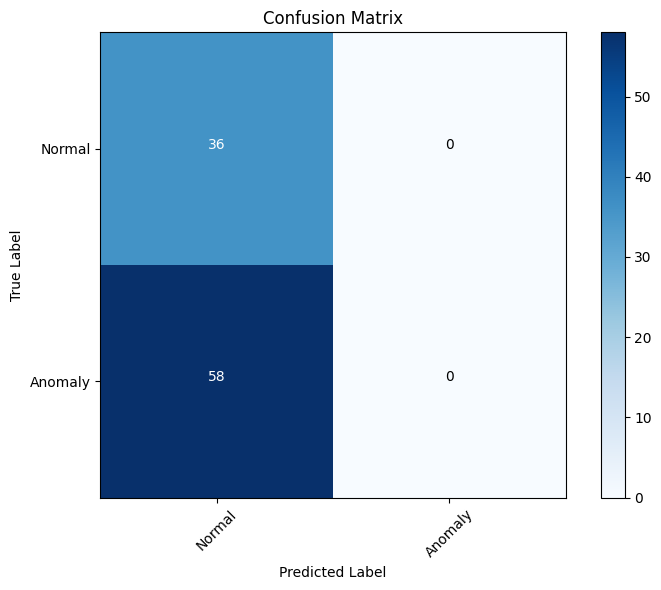

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Get the true and predicted labels from the results_dataframe
true_labels = results_dataframe['true']
predicted_labels = results_dataframe['predicted']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = ['Normal', 'Anomaly']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values to the confusion matrix plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()